<a href="https://colab.research.google.com/github/aquapathos/Demo/blob/master/TSPmini2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# 日本語フォントをダウンロードする。１度だけ実行
!apt-get -y install fonts-ipafont-gothic
# キャッシュを削除する。
!rm /root/.cache/matplotlib/fontlist-v300.json
# ランタイムを再起動する。

In [0]:
# Google Drive のマウント
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [0]:
%%bash
# pip uninstall -y pyconcorde
# 巡回セールスマン問題の最適解を求めるためのライブラリ　導入
cd /tmp
git clone https://github.com/jvkersch/pyconcorde
cd pyconcorde
pip install .
cd /content

Processing /tmp/pyconcorde
  Stored in directory: /tmp/pip-ephem-wheel-cache-600qgf5s/wheels/9b/c1/32/aa2663bd847e1c530e50377618e4c11fdaede88473fb7a4cb8
Successfully built pyconcorde
  Found existing installation: pyconcorde 0.1.0
    Uninstalling pyconcorde-0.1.0:
      Successfully uninstalled pyconcorde-0.1.0


fatal: destination path 'pyconcorde' already exists and is not an empty directory.


In [7]:
import cv2
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
import numpy as np
import tensorflow.compat.v1 as tf
import seaborn as sns
import keras
from keras.models import Sequential,Model
from keras.layers import Conv2D, MaxPooling2D, Flatten
from keras.layers import Input, Conv2DTranspose,Concatenate
from keras.layers import BatchNormalization
from keras.layers.normalization import BatchNormalization
from keras.layers import add, concatenate
import keras.backend.tensorflow_backend as KTF
from keras.callbacks import EarlyStopping, CSVLogger
from keras.layers.core import Dense, Dropout, Activation
from keras.layers import LeakyReLU
from keras.optimizers import Adam
from keras.utils import to_categorical
from keras.utils import plot_model

import pickle


Using TensorFlow backend.


In [0]:
from concorde.tsp import TSPSolver
from concorde.tests.data_utils import get_dataset_path

XSIZE = 48
YSIZE = 48
MSIZE = 1 # 周辺にとるマージン 

# 巡回する点を生成する関数
def genTSP(pnum = 3, xsize=XSIZE,ysize=YSIZE, msize = MSIZE):
    
    # 訪問地点を指定数　（pnum）重複なく生成　ただし周辺は避ける
    posnumA,  posA = [], []
    while len(posnumA)<pnum:
        a = np.random.randint(0,(xsize-2*msize)*(ysize-2*msize))
        if a not in posnumA:
            posnumA.append(a)
            y = a//(xsize-2*msize)+msize
            x = a%(xsize-2*msize)+msize
            posA.append([x,y])
 
    #  画像の生成  
    tspimg = np.zeros((ysize,xsize),np.uint8) # 問題となる画像　　

    # 選ばれた点を描く
    for [x,y] in posA:
        tspimg[y,x] = 255
        # timg = tspimg[y-1:y+2,x-1:x+2]  # 点が隣接していて重なる場合、明るい方の色で描くことにする。
        # tspimg[y-1:y+2,x-1:x+2] = np.bitwise_or(timg, np.array([[200,255,200],[255,255,255],[200,255,200]]))
        
    return np.array(posA),tspimg

Text(0.5, 1.0, '巡回地点マップ')

/usr/local/lib/python3.6/dist-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['IPAGothic'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


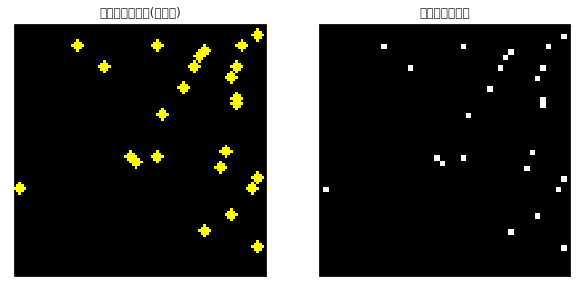

In [0]:
# 動作確認
refimg = np.zeros((2*YSIZE,2*XSIZE,3),np.uint8) # 表示拡大画像
plt.rcParams['figure.figsize'] = (10.0, 10.0)
# jp_font = {'fontname':'IPAGothic'}
sns.set(font='IPAGothic')
posA,tspimg = genTSP(25)
for [x,y] in posA:
    refimg = cv2.circle(refimg,(2*x,2*y),2,(0,255,255),-1)  # 表示用の方は少し誇張して描く
plt.subplot(1,2,1)
plt.xticks([])
plt.yticks([])
plt.imshow(refimg[:,:,::-1])
plt.title("{}".format("巡回地点マップ(表示用)"))
plt.subplot(1,2,2)
plt.xticks([])
plt.yticks([])
plt.imshow(tspimg)
plt.gray()
plt.title("{}".format("巡回地点マップ"))

# TSPの学習用データの生成（concorde法）
- https://github.com/jvkersch/pyconcorde のプログラムを使わせていただく

# Concorde TSP Solver の動作確認

/usr/local/lib/python3.6/dist-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['IPAGothic'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


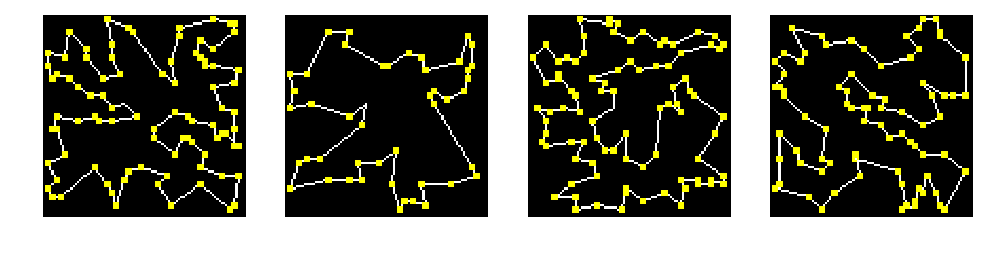

In [0]:
plt.figure(figsize=(12, 6), dpi=100)
for i in range(4):
    refimg = np.zeros((2*YSIZE,2*XSIZE,3),np.uint8) # 表示拡大画像
    plt.subplot(1, 4, i+1)
    poss, img = genTSP(pnum=np.random.randint(20,100),xsize=XSIZE,ysize=YSIZE,msize=MSIZE)
    xs = [x for [x,y] in poss]
    ys = [y for [x,y] in poss]
    solver = TSPSolver.from_data(xs,ys,norm="EUC_2D")
    solution = solver.solve()
    ps = solution.tour
    cv2.line(refimg,(2*xs[ps[0]],2*ys[ps[0]]),(2*xs[ps[-1]],2*ys[ps[-1]]),(255,255,255),1)
    p0 = ps[0]
    for p1 in ps[1:]:
      cv2.line(refimg,(2*xs[p0],2*ys[p0]),(2*xs[p1],2*ys[p1]),(255,255,255),1)
      cv2.rectangle(refimg,(2*xs[p0]-1,2*ys[p0]-1),(2*xs[p0]+1,2*ys[p0]+1),(0,255,255),-1)
      p0 = p1
    plt.imshow(refimg[:,:,::-1])
    plt.axis('off')

# TSPの問題画像と解画像の生成

In [0]:
XSIZE,YSIZE,MSIZE = 48,48,1
minP = 5
maxP = 20

# TSPの問題と答えの生成(1セット) 
def genTSPSample(minP, maxP, xsize=XSIZE, ysize=YSIZE, msize=MSIZE):
    plist, img = genTSP(pnum=np.random.randint(minP,maxP),xsize=XSIZE,ysize=YSIZE,msize=MSIZE)

    # TSP の最適解を求める
    xs = [x for [x,y] in plist]  # X座標のみのリスト
    ys = [y for [x,y] in plist]  # Y座標のみのリスト
    solver = TSPSolver.from_data(xs,ys,norm="EUC_2D")
    solution = solver.solve()
    tspsol = solution.tour # インデックス表現した解
    
    # 解画像を生成する
    simg = np.zeros_like(img)
    cv2.line(simg,(xs[ps[0]],ys[ps[0]]),(xs[tspsol[-1]],ys[tspsol[-1]]),255,1)
    p0 = tspsol[0]
    for p1 in tspsol[1:]:
        simg = cv2.line(simg,(xs[p0],ys[p0]),(xs[p1],ys[p1]),255,1)
        p0 = p1

    return (plist, tspsol, img, simg)

# TSPの解と正解のペアを指定数生成する関数
minP = 5  # 地点数の最小値
maxP = 25 # 地点数の最大値

def genTSPSamples(num = 100, minP = minP, maxP = maxP, xsize=XSIZE, ysize=YSIZE, msize=MSIZE):
    data = []  
    for i in range(num):
        data.append(genTSPSample(minP=minP, maxP=maxP, xsize=XSIZE, ysize=YSIZE, msize=MSIZE))
    return data


# 訓練例の生成
せっかく作ったデータなので，google drive にも保存しておくことにする

In [0]:
%%time

SETNUM = 2

for i in range(SETNUM):
    pset = genTSPSamples(10000)
    f = open('/gdrive/My Drive/minitest1000_'+str(i),'wb')
    pickle.dump(pset,f)
    f.close

CPU times: user 2min 4s, sys: 30.6 s, total: 2min 35s
Wall time: 3min 28s


## google drive からのデータの読み込み 

In [0]:
%%time
f1 = open('/gdrive/My Drive/minitest1000_0','rb')
f2 = open('/gdrive/My Drive/minitest1000_1','rb')
train = pickle.load(f1)
testdata = pickle.load(f2)
f1.close
f2.close

CPU times: user 168 ms, sys: 108 ms, total: 276 ms
Wall time: 2.12 s


## 読み込みデータの確認

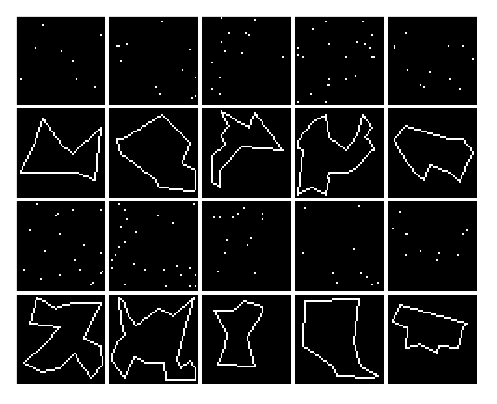

In [0]:
plt.figure(figsize=(6, 12), dpi=100)
simg = np.ones((200,250),np.uint8)*255
for j in range(5):
    i = 0
    simg[100*i:100*i+48,50*j:50*j+48] = cv2.resize(train[5*i+j][2],(48,48))
    simg[100*i+50:100*i+98,50*j:50*j+48] = cv2.resize(train[5*i+j][3],(48,48))
    i = 1
    simg[100*i:100*i+48,50*j:50*j+48] = cv2.resize(testdata[5*i+j][2],(48,48))
    simg[100*i+50:100*i+98,50*j:50*j+48] = cv2.resize(testdata[5*i+j][3],(48,48))
plt.xticks([])
plt.yticks([])
plt.gray()
plt.imshow(simg)

# CNNモデル

https://esslab.jp/~ess/publications/SimoSerraSIGGRAPH2016.pdf のネットワークを使ってみた


In [0]:
K3 = (3,3)
K5 = (5,5)
K4 = (4,4)
slope_co = 0.2 # 0ならReLU

# Model

input = Input(shape=(48,48,1))
# Layer 1  (48,48,1) -> strides2 -> (24,24,48)
conv1 = Conv2D(48, K5, padding='same', strides=2)(input)
conv1 = LeakyReLU(alpha=slope_co)(conv1)

# Layer 2  (24,24,48) -> strides1 -> (24,24,128)
conv2 = Conv2D(128, K3, padding='same', strides=1)(conv1)
conv2 = LeakyReLU(alpha=slope_co)(conv2)

# Layer 3  (24,24,128) -> strides1 -> (24,24,128)
conv3 = Conv2D(128, K3, padding='same', strides=1)(conv2)
conv3 = LeakyReLU(alpha=slope_co)(conv3)

# Layer 4  (24,24,128) -> strides2 -> (12,12,256)
conv4 = Conv2D(256, K3, strides=2, padding='same')(conv3)
conv4 = LeakyReLU(alpha=slope_co)(conv4)

# Layer 5  (12,12,256) -> strides1 -> (12,12,256)
conv5 = Conv2D(256, K3, strides=1, padding='same')(conv4)
conv5 = LeakyReLU(alpha=slope_co)(conv5)

# Layer 6  (12,12,256) -> strides1 -> (12,12,256)
conv6 = Conv2D(256, K3, strides=1, padding='same')(conv5)
conv6 = LeakyReLU(alpha=slope_co)(conv6)

# Layer 7  (12,12,256) -> strides2 -> (6,6,256)
conv7 = Conv2D(256, K3, strides=2, padding='same')(conv6)
conv7 = BatchNormalization()(conv7)
conv7 = LeakyReLU(alpha=slope_co)(conv7)

# Layer 8  (6,6,256) -> strides1 -> (6,6,512)
conv8 = Conv2D(512, K3, strides=1, padding='same')(conv7)
conv8 = LeakyReLU(alpha=slope_co)(conv8)

# Layer 9  (6,6,512) -> strides1 -> (6,6,1024)
conv9 = Conv2D(1024, K3, strides=1, padding='same')(conv8)
conv9 = Dropout(rate=0.2)(conv9)
conv9 = LeakyReLU(alpha=slope_co)(conv9)

# Layer 10  (6,6,1024) -> strides1 -> (6,6,1024)
conv10 = Conv2D(1024, K3, strides=1, padding='same')(conv9)
conv10 = Dropout(rate=0.2)(conv10)
conv10 = LeakyReLU(alpha=slope_co)(conv10)

# Layer 11  (6,6,1024) -> strides1 -> (6,6,1024)
conv11 = Conv2D(1024, K3, strides=1, padding='same')(conv10)
conv11 = Dropout(rate=0.2)(conv11)
conv11 = LeakyReLU(alpha=slope_co)(conv11)

# Layer 12  (6,6,1024) -> strides1 -> (6,6,1024)
conv12 = Conv2D(1024, K3, strides=1, padding='same')(conv11)
conv12 = Dropout(rate=0.2)(conv12)
conv12 = LeakyReLU(alpha=slope_co)(conv12)

# Layer 13  (6,6,1024) -> strides1 -> (6,6,512)
conv13 = Conv2D(512, K3, strides=1, padding='same')(conv12)
conv13 = LeakyReLU(alpha=slope_co)(conv13)

# Layer 14  (6,6,512) -> strides1 -> (6,6,256)
conv14 = Conv2D(256, K3, strides=1, padding='same')(conv13)
conv14 = LeakyReLU(alpha=slope_co)(conv14)

# Layer 15 UP (6,6,256) -> strides2 -> (12,12,256)
conv15 = Conv2DTranspose(256, K4, strides=2, padding='same')(conv14)
conv15 = LeakyReLU(alpha=slope_co)(conv15)

# Layer 16  (12,12,256) -> strides1 -> (12,12,256)
conv16 = Conv2D(256, K3, strides=1, padding='same')(conv15)
conv16 = LeakyReLU(alpha=slope_co)(conv16)

# Layer 17  (12,12,256) -> strides1 -> (12,12,128)
conv17 = Conv2D(128, K3, strides=1, padding='same')(conv16)
conv17 = LeakyReLU(alpha=slope_co)(conv17)

# Layer 18 UP (12,12,128) -> strides2 -> (24,24,128)
conv18 = Conv2DTranspose(128, K4, strides=2, padding='same')(conv17)
conv18 = LeakyReLU(alpha=slope_co)(conv18)

# Layer 19  (24,24,128) -> strides1 -> (24,24,128)
conv19 = Conv2D(128, K3, strides=1, padding='same')(conv18)
conv19 = LeakyReLU(alpha=slope_co)(conv19)

# Layer 20  (24,24,128) -> strides1 -> (24,24,48)
conv20 = Conv2D(48, K3, strides=1, padding='same')(conv19)
conv20 = LeakyReLU(alpha=slope_co)(conv20)

# Layer 21 UP (24,24,48) -> strides2 -> (48,48,48)
conv21 = Conv2DTranspose(48, K4, strides=2, padding='same')(conv20)
conv21 = LeakyReLU(alpha=slope_co)(conv21)

# Layer 22  (48,48,48) -> strides1 -> (48,48,24)
conv22 = Conv2D(24, K3, strides=1, padding='same')(conv21)
conv22 = LeakyReLU(alpha=slope_co)(conv22)

# Layer 23  (48,48,24) -> strides1 -> (48,48,1)
output = Conv2D(1, K3, strides=1, padding='same')(conv22)
output = Activation('relu')(output)

model = Model(input,output)

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         (None, 48, 48, 1)         0         
_________________________________________________________________
conv2d_142 (Conv2D)          (None, 24, 24, 48)        1248      
_________________________________________________________________
leaky_re_lu_153 (LeakyReLU)  (None, 24, 24, 48)        0         
_________________________________________________________________
conv2d_143 (Conv2D)          (None, 24, 24, 128)       55424     
_________________________________________________________________
leaky_re_lu_154 (LeakyReLU)  (None, 24, 24, 128)       0         
_________________________________________________________________
conv2d_144 (Conv2D)          (None, 24, 24, 128)       147584    
_________________________________________________________________
leaky_re_lu_155 (LeakyReLU)  (None, 24, 24, 128)       0         
__________

/content


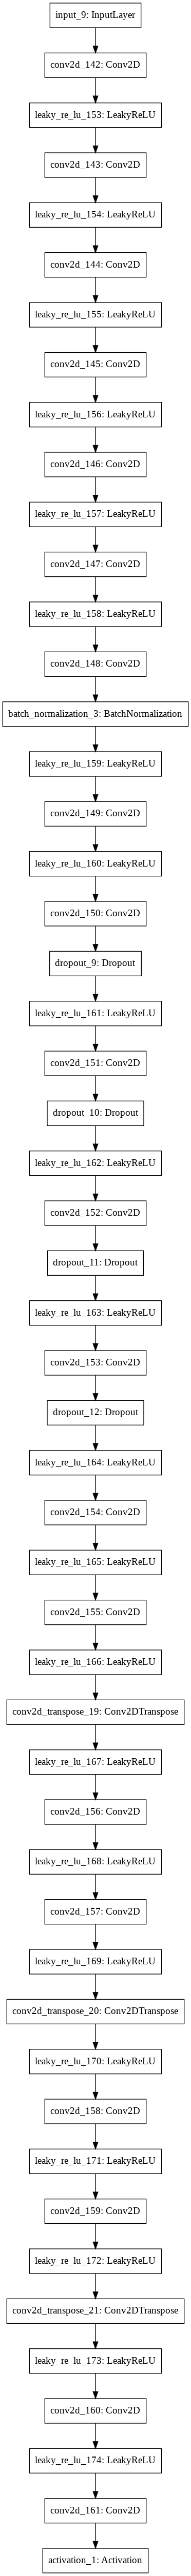

In [0]:
from IPython.display import Image, display_png
%cd /content
#学習モデル図の作成
plot_model(model, to_file='orig_model.png')
display_png(Image('orig_model.png'))

In [0]:
model.compile(loss= 'mean_squared_error',#  'binary_crossentropy',#   # 'binary_crossentropy', # ,
              # optimizer = keras.optimizers.Adamax(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0),
              optimizer = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0),
              # optimizer = keras.optimizers.SGD(lr=0.01, momentum=0.0, decay=0.0, nesterov=False),
              metrics=['accuracy'])

In [0]:
X,Y = [],[]
for atsp in train:
    (_plist, _tspsol, x, y) = atsp
    X.append(x)
    Y.append(y)

dsize = len(X)
batch_size = 32
epochs = 100

X1 = np.array(X).reshape(dsize,48,48,1).astype('float32')
X1 = X1/255

Y1 = np.array(Y).reshape(dsize,48,48,1).astype('float32')              
Y1 = Y1/255

es = EarlyStopping(monitor='val_loss', patience=2)   #  検証用データのロスが改善されなくなったら2エポック後に停止
tb_cb = keras.callbacks.TensorBoard(log_dir='tblog', histogram_freq=1, write_graph=True)
csv_logger = CSVLogger('training.log')
hist = model.fit(X1, Y1,
                 batch_size=batch_size,
                 epochs=epochs,
                 verbose=1,
                 validation_split=0.5, # 50 % は検証用に利用する
                 #callbacks=[es, csv_logger,tb_cb])
                 callbacks=[es, csv_logger])


Train on 5000 samples, validate on 5000 samples
Epoch 1/100
5000/5000 [==============================] - 31s 6ms/step - loss: 0.0542 - acc: 0.9407 - val_loss: 0.0509 - val_acc: 0.9406
Epoch 2/100
5000/5000 [==============================] - 27s 5ms/step - loss: 0.0468 - acc: 0.9410 - val_loss: 0.0452 - val_acc: 0.9409
Epoch 3/100
5000/5000 [==============================] - 27s 5ms/step - loss: 0.0424 - acc: 0.9436 - val_loss: 0.0407 - val_acc: 0.9456
Epoch 4/100
5000/5000 [==============================] - 28s 6ms/step - loss: 0.0390 - acc: 0.9476 - val_loss: 0.0405 - val_acc: 0.9451
Epoch 5/100
5000/5000 [==============================] - 28s 6ms/step - loss: 0.0366 - acc: 0.9509 - val_loss: 0.0367 - val_acc: 0.9513
Epoch 6/100
5000/5000 [==============================] - 28s 6ms/step - loss: 0.0346 - acc: 0.9535 - val_loss: 0.0349 - val_acc: 0.9537
Epoch 7/100
5000/5000 [==============================] - 28s 6ms/step - loss: 0.0332 - acc: 0.9556 - val_loss: 0.0359 - val_acc: 0.9522


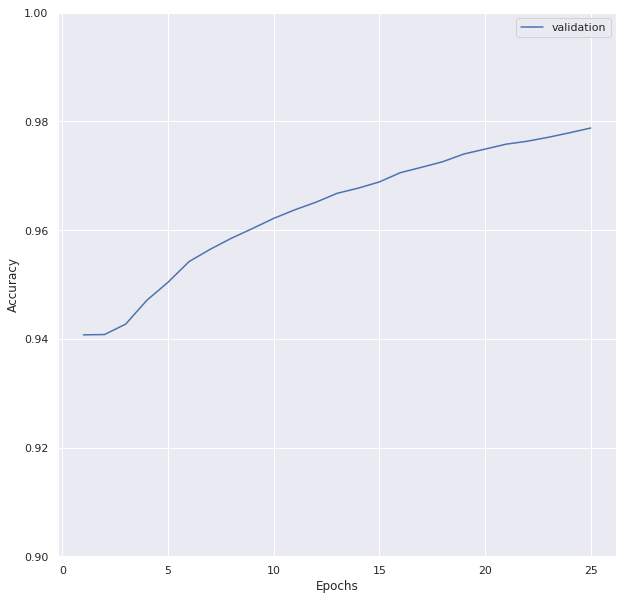

In [0]:
x = hist.history['acc']
plt.plot(range(1, len(x)+1), x,label="validation")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim([0.9, 1])
plt.legend()
plt.show()

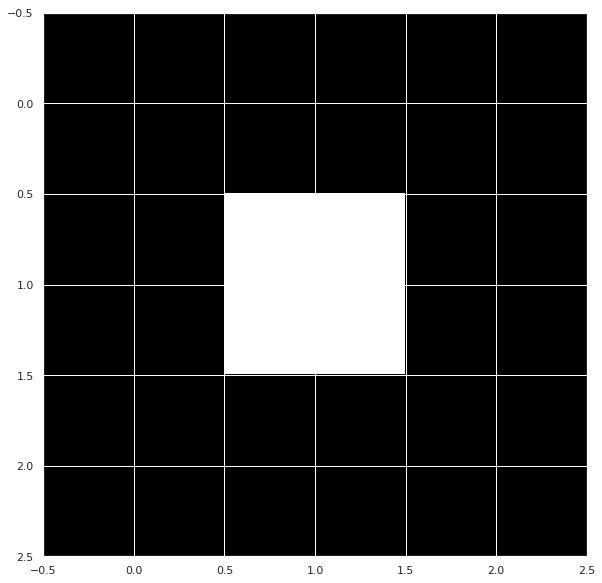

In [0]:
plt.imshow(np.array([[255,255,255],[255,0,255],[255,255,255]]),cmap=plt.cm.binary)

0.0 1.0
0.0 1.0
0.0 1.0
0.0 1.0
0.0 1.0
0.0 1.0
0.0 1.0
0.0 1.0
0.0 1.0
0.0 1.0


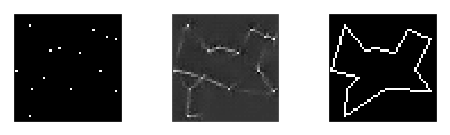

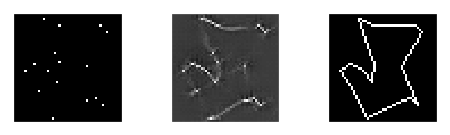

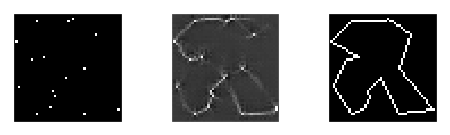

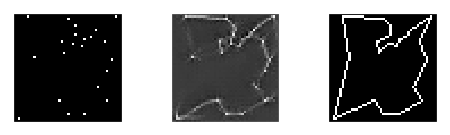

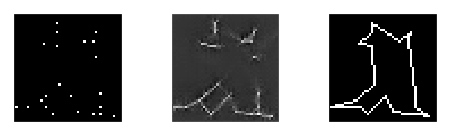

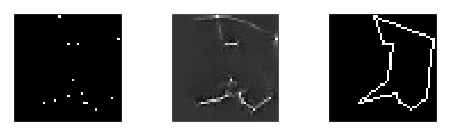

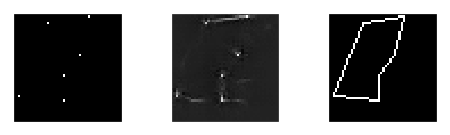

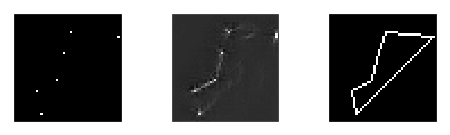

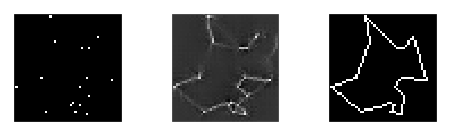

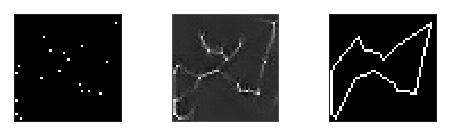

In [0]:
def test(X,Y,model):
    output = model.predict(X.reshape(1,48,48,1))
    # output = (output*255).astype(np.uint8)
    output = np.ndarray.flatten(output)
    output = output.reshape(48,48)
    fig = plt.figure(figsize=(8,2))
    subplot = fig.add_subplot(1,3,1)
    subplot.set_xticks([])
    subplot.set_yticks([])
    subplot.imshow(X.reshape(48,48))
    subplot = fig.add_subplot(1,3,2)
    subplot.set_xticks([])
    subplot.set_yticks([])
    output = (output-output.min())/(output.max()-output.min())
    subplot.imshow(output)
    subplot = fig.add_subplot(1,3,3)
    subplot.set_xticks([])
    subplot.set_yticks([])
    subplot.imshow(Y.reshape(48,48))
    return output
    
for i in range(10):
    (_,_,img,simg) = train[i+249]
    output = test(img,simg,model)
    print(output.min(),output.max())

# スキップコネクションの効果はあるのか？

In [0]:
K3 = (3,3)
K5 = (5,5)
K4 = (4,4)
slope_co = 0.2 # 0ならReLU

# Model

input = Input(shape=(48,48,1))
# Layer 1  (48,48,1) -> strides2 -> (24,24,48)
conv1 = Conv2D(48, K5, padding='same', strides=2)(input)
conv1 = LeakyReLU(alpha=slope_co)(conv1)

# Layer 2  (24,24,48) -> strides1 -> (24,24,128)
conv2 = Conv2D(128, K3, padding='same', strides=1)(conv1)
conv2 = LeakyReLU(alpha=slope_co)(conv2)

# Layer 3  (24,24,128) -> strides1 -> (24,24,128)
conv3 = Conv2D(128, K3, padding='same', strides=1)(conv2)
conv3 = LeakyReLU(alpha=slope_co)(conv3)

# Layer 4  (24,24,128) -> strides2 -> (12,12,256)
conv4 = Conv2D(256, K3, strides=2, padding='same')(conv3)
conv4 = LeakyReLU(alpha=slope_co)(conv4)

# Layer 5  (12,12,256) -> strides1 -> (12,12,256)
conv5 = Conv2D(256, K3, strides=1, padding='same')(conv4)
conv5 = LeakyReLU(alpha=slope_co)(conv5)

# Layer 6  (12,12,256) -> strides1 -> (12,12,256)
conv6 = Conv2D(256, K3, strides=1, padding='same')(conv5)
conv6 = LeakyReLU(alpha=slope_co)(conv6)

# Layer 7  (12,12,256) -> strides2 -> (6,6,256)
conv7 = Conv2D(256, K3, strides=2, padding='same')(conv6)
conv7 = BatchNormalization()(conv7)
conv7 = LeakyReLU(alpha=slope_co)(conv7)

# Layer 8  (6,6,256) -> strides1 -> (6,6,512)
conv8 = Conv2D(512, K3, strides=1, padding='same')(conv7)
conv8 = LeakyReLU(alpha=slope_co)(conv8)

# Layer 9  (6,6,512) -> strides1 -> (6,6,1024)
conv9 = Conv2D(1024, K3, strides=1, padding='same')(conv8)
conv9 = Dropout(rate=0.2)(conv9)
conv9 = LeakyReLU(alpha=slope_co)(conv9)

# Layer 10  (6,6,1024) -> strides1 -> (6,6,1024)
conv10 = Conv2D(1024, K3, strides=1, padding='same')(conv9)
conv10 = Dropout(rate=0.2)(conv10)
conv10 = LeakyReLU(alpha=slope_co)(conv10)

# Layer 11  (6,6,1024) -> strides1 -> (6,6,1024)
conv11 = Conv2D(1024, K3, strides=1, padding='same')(conv10)
conv11 = Dropout(rate=0.2)(conv11)
conv11 = LeakyReLU(alpha=slope_co)(conv11)

# Layer 12  (6,6,1024) -> strides1 -> (6,6,1024)
conv12 = Conv2D(1024, K3, strides=1, padding='same')(conv11)
conv12 = Dropout(rate=0.2)(conv12)
conv12 = LeakyReLU(alpha=slope_co)(conv12)

# Layer 13  (6,6,1024) -> strides1 -> (6,6,512)
conv13 = Conv2D(512, K3, strides=1, padding='same')(conv12)
conv13 = LeakyReLU(alpha=slope_co)(conv13)

# Layer 14  (6,6,512) -> strides1 -> (6,6,256)
conv14 = Conv2D(256, K3, strides=1, padding='same')(conv13)
conv14 = LeakyReLU(alpha=slope_co)(conv14)
conv14 = concatenate([conv7,conv14])

# Layer 15 UP (6,6,256) -> strides2 -> (12,12,256)
conv15 = Conv2DTranspose(256, K4, strides=2, padding='same')(conv14)
conv15 = LeakyReLU(alpha=slope_co)(conv15)

# Layer 16  (12,12,256) -> strides1 -> (12,12,256)
conv16 = Conv2D(256, K3, strides=1, padding='same')(conv15)
conv16 = LeakyReLU(alpha=slope_co)(conv16)

# Layer 17  (12,12,256) -> strides1 -> (12,12,128)
conv17 = Conv2D(128, K3, strides=1, padding='same')(conv16)
conv17 = LeakyReLU(alpha=slope_co)(conv17)
conv17 = concatenate([conv6,conv17])

# Layer 18 UP (12,12,128) -> strides2 -> (24,24,128)
conv18 = Conv2DTranspose(128, K4, strides=2, padding='same')(conv17)
conv18 = LeakyReLU(alpha=slope_co)(conv18)

# Layer 19  (24,24,128) -> strides1 -> (24,24,128)
conv19 = Conv2D(128, K3, strides=1, padding='same')(conv18)
conv19 = LeakyReLU(alpha=slope_co)(conv19)

# Layer 20  (24,24,128) -> strides1 -> (24,24,48)
conv20 = Conv2D(48, K3, strides=1, padding='same')(conv19)
conv20 = LeakyReLU(alpha=slope_co)(conv20)
conv20 = concatenate([conv3,conv20])

# Layer 21 UP (24,24,48) -> strides2 -> (48,48,48)
conv21 = Conv2DTranspose(48, K4, strides=2, padding='same')(conv20)
conv21 = LeakyReLU(alpha=slope_co)(conv21)

# Layer 22  (48,48,48) -> strides1 -> (48,48,24)
conv22 = Conv2D(24, K3, strides=1, padding='same')(conv21)
conv22 = LeakyReLU(alpha=slope_co)(conv22)

# Layer 23  (48,48,24) -> strides1 -> (48,48,1)
output = Conv2D(1, K3, strides=1, padding='same')(conv22)
#output = Activation('relu')(output)

model = Model(input,output)

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            (None, 48, 48, 1)    0                                            
__________________________________________________________________________________________________
conv2d_122 (Conv2D)             (None, 24, 24, 48)   1248        input_8[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu_131 (LeakyReLU)     (None, 24, 24, 48)   0           conv2d_122[0][0]                 
__________________________________________________________________________________________________
conv2d_123 (Conv2D)             (None, 24, 24, 128)  55424       leaky_re_lu_131[0][0]            
__________________________________________________________________________________________________
leaky_re_l

/content


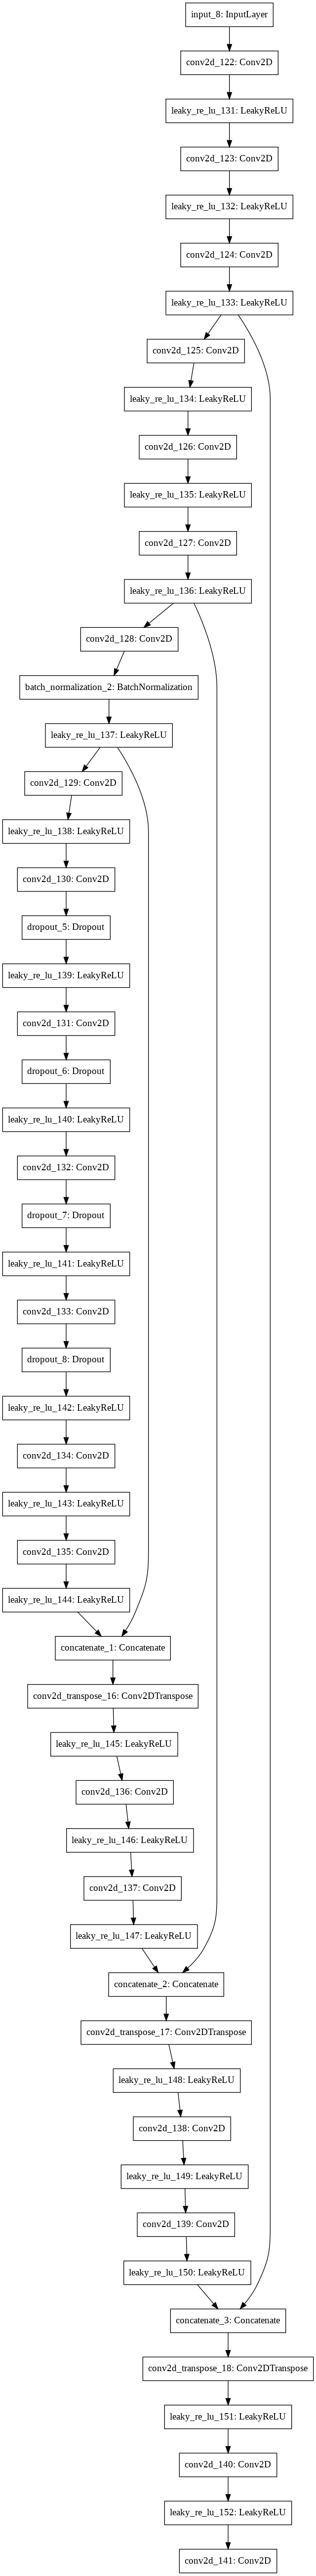

In [0]:
from IPython.display import Image, display_png
%cd /content
#学習モデル図の作成
plot_model(model, to_file='orig_model.png')
display_png(Image('orig_model.png'))

In [0]:
model.compile(loss= 'binary_crossentropy', #'mean_squared_error',#  'binary_crossentropy',#   # # ,
              # optimizer = keras.optimizers.Adamax(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0),
              optimizer = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0),
              # optimizer = keras.optimizers.SGD(lr=0.01, momentum=0.0, decay=0.0, nesterov=False),
              metrics=['accuracy'])

W0625 09:41:11.299452 139708299016064 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [0]:
X,Y = [],[]
for atsp in train:
    (_plist, _tspsol, x, y) = atsp
    X.append(x)
    Y.append(y)

dsize = len(X)
batch_size = 32
epochs = 100

X1 = np.array(X).reshape(dsize,48,48,1).astype('float32')
X1 = X1/255

Y1 = np.array(Y).reshape(dsize,48,48,1).astype('float32')              
Y1 = Y1/255

es = EarlyStopping(monitor='val_loss', patience=2)   #  検証用データのロスが改善されなくなったら2エポック後に停止
tb_cb = keras.callbacks.TensorBoard(log_dir='tblog', histogram_freq=1, write_graph=True)
csv_logger = CSVLogger('training.log')
hist = model.fit(X1, Y1,
                 batch_size=batch_size,
                 epochs=epochs,
                 verbose=1,
                 validation_split=0.5, # 50 % は検証用に利用する
                 #callbacks=[es, csv_logger,tb_cb])
                 callbacks=[es, csv_logger])


Train on 5000 samples, validate on 5000 samples
Epoch 1/100
5000/5000 [==============================] - 33s 7ms/step - loss: 0.0528 - acc: 0.9843 - val_loss: 0.1269 - val_acc: 0.9722
Epoch 2/100
5000/5000 [==============================] - 30s 6ms/step - loss: 0.0444 - acc: 0.9861 - val_loss: 0.1195 - val_acc: 0.9742
Epoch 3/100
5000/5000 [==============================] - 30s 6ms/step - loss: 0.0301 - acc: 0.9904 - val_loss: 0.1310 - val_acc: 0.9730
Epoch 4/100
5000/5000 [==============================] - 31s 6ms/step - loss: 0.0631 - acc: 0.9808 - val_loss: 0.1219 - val_acc: 0.9696


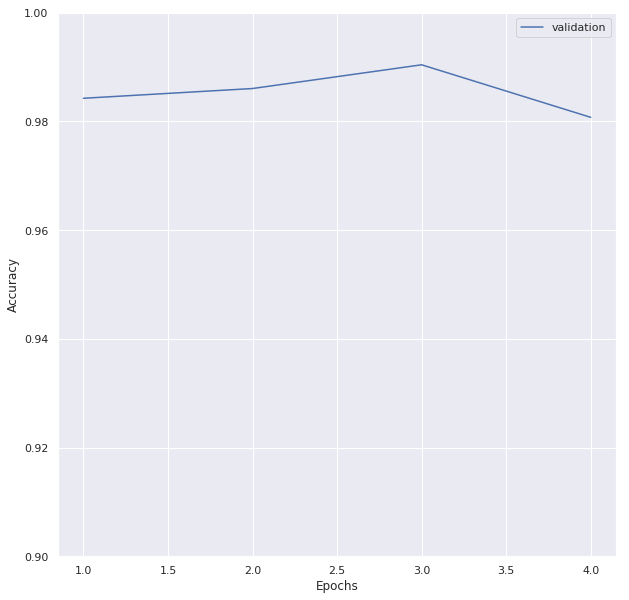

In [0]:
x = hist.history['acc']
plt.plot(range(1, len(x)+1), x,label="validation")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim([0.9, 1])
plt.legend()
plt.show()

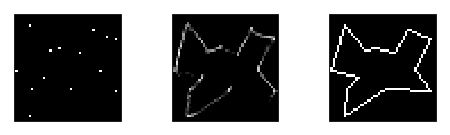

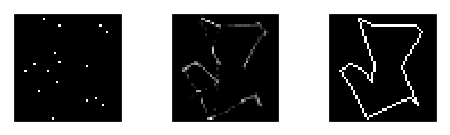

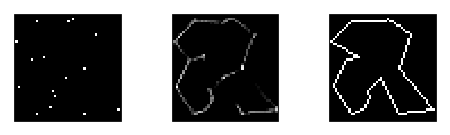

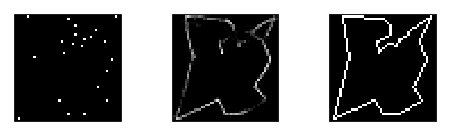

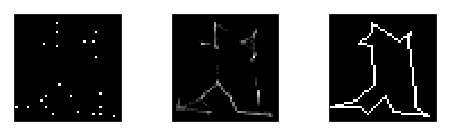

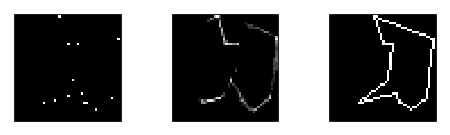

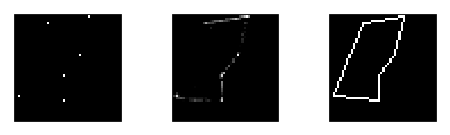

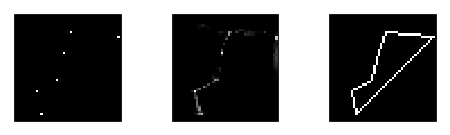

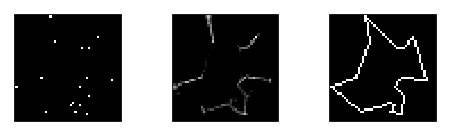

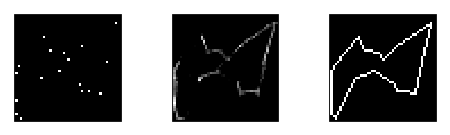

In [0]:
def test(X,Y,model):
    output = model.predict(X.reshape(1,48,48,1))
    output1 = output.reshape(48,48)
    output = output1
    fig = plt.figure(figsize=(8,2))
    subplot = fig.add_subplot(1,3,1)
    subplot.set_xticks([])
    subplot.set_yticks([])
    subplot.imshow(X.reshape(48,48))
    subplot = fig.add_subplot(1,3,2)
    subplot.set_xticks([])
    subplot.set_yticks([])
    subplot.imshow(output)
    subplot = fig.add_subplot(1,3,3)
    subplot.set_xticks([])
    subplot.set_yticks([])
    subplot.imshow(Y.reshape(48,48))
    
for i in range(10):
    (_,_,img,simg) = train[i+249]
    test(img,simg,model)
    

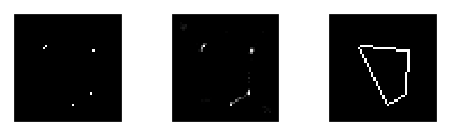

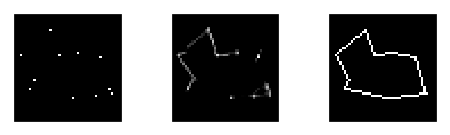

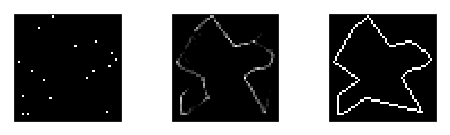

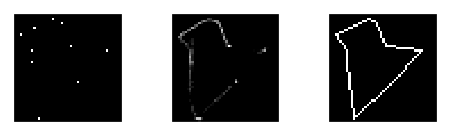

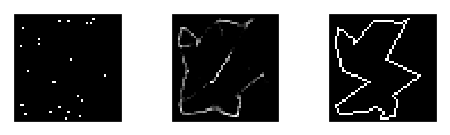

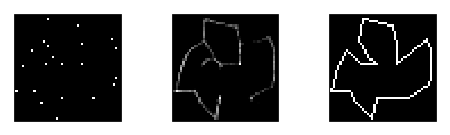

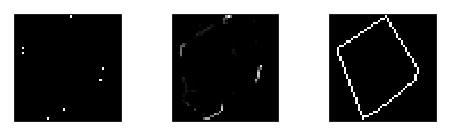

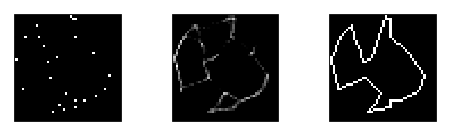

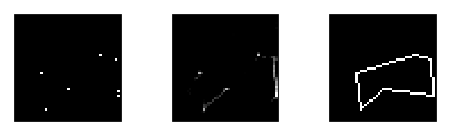

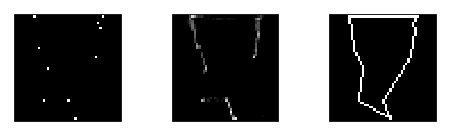

In [0]:
for i in range(10):
    (_,_,img,simg) = testdata[i+249]
    test(img,simg,model)

In [0]:
K3 = (3,3)
K5 = (5,5)
K4 = (4,4)
slope_co = 0.0 # 0ならReLU

# Model

input = Input(shape=(48,48,1))
# Layer 1  (48,48,1) -> strides2 -> (24,24,48)
conv1 = Conv2D(48, K5, padding='same', strides=2)(input)
conv1 = LeakyReLU(alpha=slope_co)(conv1)

# Layer 2  (24,24,48) -> strides1 -> (24,24,128)
conv2 = Conv2D(128, K3, padding='same', strides=1)(conv1)
conv2 = LeakyReLU(alpha=slope_co)(conv2)

# Layer 3  (24,24,128) -> strides1 -> (24,24,128)
conv3 = Conv2D(128, K3, padding='same', strides=1)(conv2)
conv3 = LeakyReLU(alpha=slope_co)(conv3)

# Layer 4  (24,24,128) -> strides2 -> (12,12,256)
conv4 = Conv2D(256, K3, strides=2, padding='same')(conv3)
conv4 = LeakyReLU(alpha=slope_co)(conv4)

# Layer 5  (12,12,256) -> strides1 -> (12,12,256)
conv5 = Conv2D(256, K3, strides=1, padding='same')(conv4)
conv5 = LeakyReLU(alpha=slope_co)(conv5)

# Layer 6  (12,12,256) -> strides1 -> (12,12,256)
conv6 = Conv2D(256, K3, strides=1, padding='same')(conv5)
conv6 = LeakyReLU(alpha=slope_co)(conv6)

# Layer 7  (12,12,256) -> strides2 -> (6,6,256)
conv7 = Conv2D(256, K3, strides=2, padding='same')(conv6)
conv7 = BatchNormalization()(conv7)
conv7 = LeakyReLU(alpha=slope_co)(conv7)

# Layer 8  (6,6,256) -> strides1 -> (6,6,512)
#conv8 = Conv2D(512, K3, strides=1, padding='same')(conv7)
#conv8 = Dropout(rate=0.2)(conv8)
#conv8 = LeakyReLU(alpha=slope_co)(conv8)

# Layer 9  (6,6,512) -> strides1 -> (6,6,1024)
#conv9 = Conv2D(1024, K3, strides=1, padding='same')(conv8)
#conv9 = Dropout(rate=0.2)(conv9)
#conv9 = LeakyReLU(alpha=slope_co)(conv9)
# Layer 10  (6,6,1024) -> strides1 -> (6,6,1024)
#conv10 = Conv2D(1024, K3, strides=1, padding='same')(conv9)
#conv10 = Dropout(rate=0.2)(conv10)
#conv10 = LeakyReLU(alpha=slope_co)(conv10)

# Layer 11  (6,6,1024) -> strides1 -> (6,6,1024)
#conv11 = Conv2D(1024, K3, strides=1, padding='same')(conv10)
#conv11 = LeakyReLU(alpha=slope_co)(conv11)

# Layer 12  (6,6,1024) -> strides1 -> (6,6,1024)
#conv12 = Conv2D(1024, K3, strides=1, padding='same')(conv11)
#conv12 = Dropout(rate=0.2)(conv12)
#conv12 = LeakyReLU(alpha=slope_co)(conv12)

# Layer 13  (6,6,1024) -> strides1 -> (6,6,512)
conv13 = Conv2D(512, K3, strides=1, padding='same')(conv7)
conv13 = Dropout(rate=0.2)(conv13)
conv13 = LeakyReLU(alpha=slope_co)(conv13)

# Layer 14  (6,6,512) -> strides1 -> (6,6,256)
conv14 = Conv2D(256, K3, strides=1, padding='same')(conv13)
conv14 = LeakyReLU(alpha=slope_co)(conv14)
conv14 = concatenate([conv7,conv14])

# Layer 15 UP (6,6,256) -> strides2 -> (12,12,256)
conv15 = Conv2DTranspose(256, K4, strides=2, padding='same')(conv14)
conv15 = LeakyReLU(alpha=slope_co)(conv15)

# Layer 16  (12,12,256) -> strides1 -> (12,12,256)
conv16 = Conv2D(256, K3, strides=1, padding='same')(conv15)
conv16 = LeakyReLU(alpha=slope_co)(conv16)

# Layer 17  (12,12,256) -> strides1 -> (12,12,128)
conv17 = Conv2D(128, K3, strides=1, padding='same')(conv16)
conv17 = LeakyReLU(alpha=slope_co)(conv17)
conv17 = concatenate([conv6,conv17])

# Layer 18 UP (12,12,128) -> strides2 -> (24,24,128)
conv18 = Conv2DTranspose(128, K4, strides=2, padding='same')(conv17)
conv18 = LeakyReLU(alpha=slope_co)(conv18)

# Layer 19  (24,24,128) -> strides1 -> (24,24,128)
conv19 = Conv2D(128, K3, strides=1, padding='same')(conv18)
conv19 = LeakyReLU(alpha=slope_co)(conv19)

# Layer 20  (24,24,128) -> strides1 -> (24,24,48)
conv20 = Conv2D(48, K3, strides=1, padding='same')(conv19)
conv20 = LeakyReLU(alpha=slope_co)(conv20)
conv20 = concatenate([conv3,conv20])

# Layer 21 UP (24,24,48) -> strides2 -> (48,48,48)
conv21 = Conv2DTranspose(48, K4, strides=2, padding='same')(conv20)
conv21 = LeakyReLU(alpha=slope_co)(conv21)

# Layer 22  (48,48,48) -> strides1 -> (48,48,24)
conv22 = Conv2D(24, K3, strides=1, padding='same')(conv21)
conv22 = LeakyReLU(alpha=slope_co)(conv22)

# Layer 23  (48,48,24) -> strides1 -> (48,48,1)
output = Conv2D(1, K3, strides=1, padding='same')(conv22)
# output = Activation('relu')(output)

model = Model(input,output)

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_21 (InputLayer)           (None, 48, 48, 1)    0                                            
__________________________________________________________________________________________________
conv2d_325 (Conv2D)             (None, 24, 24, 48)   1248        input_21[0][0]                   
__________________________________________________________________________________________________
leaky_re_lu_358 (LeakyReLU)     (None, 24, 24, 48)   0           conv2d_325[0][0]                 
__________________________________________________________________________________________________
conv2d_326 (Conv2D)             (None, 24, 24, 128)  55424       leaky_re_lu_358[0][0]            
__________________________________________________________________________________________________
leaky_re_l

In [0]:
model.compile(loss= 'mse', #'binary_crossentropy',#   # # 'mean_squared_error',#'
              # optimizer = keras.optimizers.Adamax(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0),
              optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0),
              # optimizer = keras.optimizers.SGD(lr=0.01, momentum=0.0, decay=0.0, nesterov=False),
              metrics=['accuracy'])

In [0]:
X,Y = [],[]
for atsp in train:
    (_plist, _tspsol, x, y) = atsp
    X.append(x)
    Y.append(y)

dsize = len(X)
batch_size = 32
epochs = 100

X1 = np.array(X).reshape(dsize,48,48,1).astype('float32')
X1 = X1/255

Y1 = np.array(Y).reshape(dsize,48,48,1).astype('float32')              
Y1 = Y1/255

es = EarlyStopping(monitor='val_loss', patience=2)   #  検証用データのロスが改善されなくなったら2エポック後に停止
tb_cb = keras.callbacks.TensorBoard(log_dir='tblog', histogram_freq=1, write_graph=True)
csv_logger = CSVLogger('training.log')
hist = model.fit(X1, Y1,
                 batch_size=batch_size,
                 epochs=epochs,
                 verbose=1,
                 validation_split=0.5, # 50 % は検証用に利用する
                 #callbacks=[es, csv_logger,tb_cb])
                 callbacks=[es, csv_logger])


Train on 5000 samples, validate on 5000 samples
Epoch 1/100
3360/5000 [===================>..........] - ETA: 2s - loss: 0.0070 - acc: 0.9922

KeyboardInterrupt: ignored

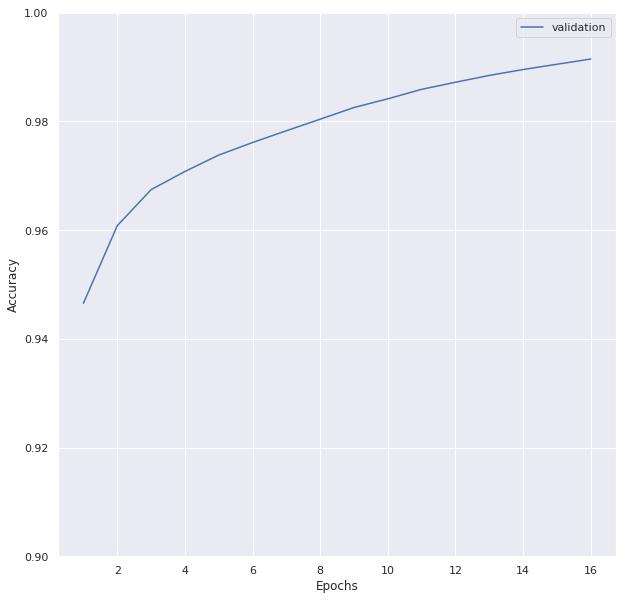

In [0]:
x = hist.history['acc']
plt.plot(range(1, len(x)+1), x,label="validation")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim([0.9, 1])
plt.legend()
plt.show()

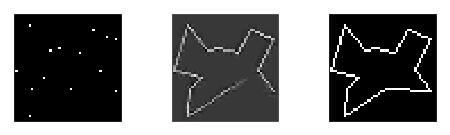

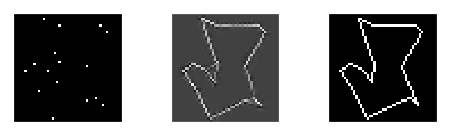

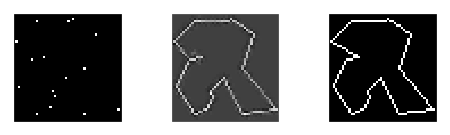

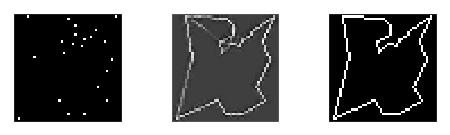

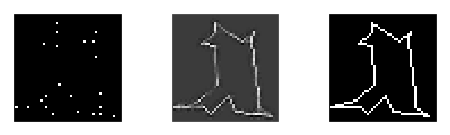

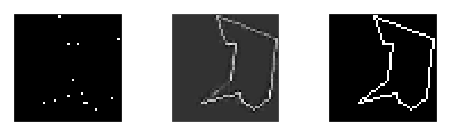

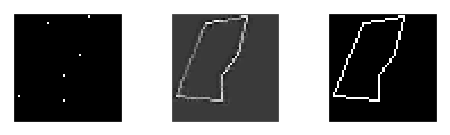

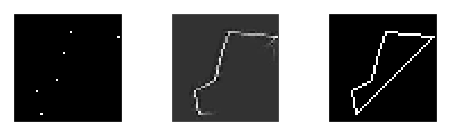

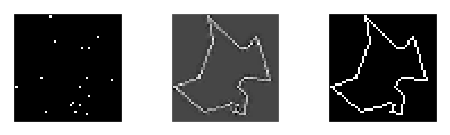

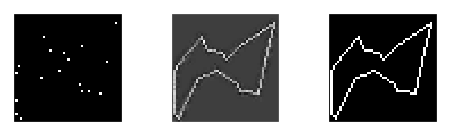

In [0]:
def test(X,Y,model):
    output = model.predict(X.reshape(1,48,48,1))
    output1 = output.reshape(48,48)
    output = output1
    fig = plt.figure(figsize=(8,2))
    subplot = fig.add_subplot(1,3,1)
    subplot.set_xticks([])
    subplot.set_yticks([])
    subplot.imshow(X.reshape(48,48))
    subplot = fig.add_subplot(1,3,2)
    subplot.set_xticks([])
    subplot.set_yticks([])
    subplot.imshow(output)
    subplot = fig.add_subplot(1,3,3)
    subplot.set_xticks([])
    subplot.set_yticks([])
    subplot.imshow(Y.reshape(48,48))
    
for i in range(10):
    (_,_,img,simg) = train[i+249]
    test(img,simg,model)
    

In [8]:
K3 = (3,3)
K5 = (5,5)
K4 = (4,4)
slope_co = 0.0 # 0ならReLU

# Model

input = Input(shape=(48,48,1))
# Layer 2  (48,48,1) -> strides1 -> (48,48,512)
conv0 = Conv2D(512, K3, padding='same', strides=1)(input)
conv0 = Dropout(rate=0.5)(conv0)
conv0 = LeakyReLU(alpha=slope_co)(conv0)

# Layer 1  (48,48,512) -> strides2 -> (24,24,48)
conv1 = Conv2D(48, K4, padding='same', strides=2)(conv0)
conv1 = LeakyReLU(alpha=slope_co)(conv1)

# Layer 2  (24,24,48) -> strides1 -> (24,24,128)
conv2 = Conv2D(128, K3, padding='same', strides=1)(conv1)
conv2 = LeakyReLU(alpha=slope_co)(conv2)

# Layer 3  (24,24,128) -> strides1 -> (24,24,128)
conv3 = Conv2D(128, K3, padding='same', strides=1)(conv2)
conv3 = LeakyReLU(alpha=slope_co)(conv3)

# Layer 4  (24,24,128) -> strides2 -> (12,12,256)
conv4 = Conv2D(256, K4, strides=2, padding='same')(conv3)
conv4 = LeakyReLU(alpha=slope_co)(conv4)

# Layer 5  (12,12,256) -> strides1 -> (12,12,256)
conv5 = Conv2D(256, K3, strides=1, padding='same')(conv4)
conv5 = LeakyReLU(alpha=slope_co)(conv5)

# Layer 6  (12,12,256) -> strides1 -> (12,12,256)
conv6 = Conv2D(256, K3, strides=1, padding='same')(conv5)
conv6 = LeakyReLU(alpha=slope_co)(conv6)

# Layer 7  (12,12,256) -> strides2 -> (6,6,256)
conv7 = Conv2D(256, K4, strides=2, padding='same')(conv6)
conv7 = BatchNormalization()(conv7)
conv7 = LeakyReLU(alpha=slope_co)(conv7)

# Layer 8  (6,6,256) -> strides1 -> (6,6,512)
conv8 = Conv2D(512, K3, strides=1, padding='same')(conv7)
conv8 = Dropout(rate=0.5)(conv8)
conv8 = LeakyReLU(alpha=slope_co)(conv8)

# Layer 9  (6,6,512) -> strides1 -> (6,6,1024)
#conv9 = Conv2D(1024, K3, strides=1, padding='same')(conv8)
#conv9 = Dropout(rate=0.2)(conv9)
#conv9 = LeakyReLU(alpha=slope_co)(conv9)
# Layer 10  (6,6,1024) -> strides1 -> (6,6,1024)
#conv10 = Conv2D(1024, K3, strides=1, padding='same')(conv9)
#conv10 = Dropout(rate=0.2)(conv10)
#conv10 = LeakyReLU(alpha=slope_co)(conv10)

# Layer 11  (6,6,1024) -> strides1 -> (6,6,1024)
#conv11 = Conv2D(1024, K3, strides=1, padding='same')(conv10)
#conv11 = LeakyReLU(alpha=slope_co)(conv11)

# Layer 12  (6,6,1024) -> strides1 -> (6,6,1024)
#conv12 = Conv2D(1024, K3, strides=1, padding='same')(conv11)
#conv12 = Dropout(rate=0.2)(conv12)
#conv12 = LeakyReLU(alpha=slope_co)(conv12)

# Layer 13  (6,6,1024) -> strides1 -> (6,6,512)
conv13 = Conv2D(512, K3, strides=1, padding='same')(conv8)
conv13 = Dropout(rate=0.5)(conv13)
conv13 = BatchNormalization()(conv13)
conv13 = LeakyReLU(alpha=slope_co)(conv13)

# Layer 14  (6,6,512) -> strides1 -> (6,6,256)
conv14 = Conv2D(256, K3, strides=1, padding='same')(conv13)
conv14 = LeakyReLU(alpha=slope_co)(conv14)
conv14 = concatenate([conv7,conv14])

# Layer 15 UP (6,6,256) -> strides2 -> (12,12,256)
conv15 = Conv2DTranspose(256, K4, strides=2, padding='same')(conv14)
conv15 = LeakyReLU(alpha=slope_co)(conv15)

# Layer 16  (12,12,256) -> strides1 -> (12,12,256)
conv16 = Conv2D(256, K3, strides=1, padding='same')(conv15)
conv16 = LeakyReLU(alpha=slope_co)(conv16)

# Layer 17  (12,12,256) -> strides1 -> (12,12,128)
conv17 = Conv2D(128, K3, strides=1, padding='same')(conv16)
conv17 = LeakyReLU(alpha=slope_co)(conv17)
conv17 = concatenate([conv6,conv17])

# Layer 18 UP (12,12,128) -> strides2 -> (24,24,128)
conv18 = Conv2DTranspose(128, K4, strides=2, padding='same')(conv17)
conv18 = LeakyReLU(alpha=slope_co)(conv18)

# Layer 19  (24,24,128) -> strides1 -> (24,24,128)
conv19 = Conv2D(128, K3, strides=1, padding='same')(conv18)
conv19 = LeakyReLU(alpha=slope_co)(conv19)

# Layer 20  (24,24,128) -> strides1 -> (24,24,48)
conv20 = Conv2D(48, K3, strides=1, padding='same')(conv19)
conv20 = LeakyReLU(alpha=slope_co)(conv20)
conv20 = concatenate([conv3,conv20])

# Layer 21 UP (24,24,48) -> strides2 -> (48,48,48)
conv21 = Conv2DTranspose(48, K4, strides=2, padding='same')(conv20)
conv21 = LeakyReLU(alpha=slope_co)(conv21)

# Layer 22  (48,48,48) -> strides1 -> (48,48,24)
conv22 = Conv2D(24, K3, strides=1, padding='same')(conv21)
conv22 = LeakyReLU(alpha=slope_co)(conv22)

# Layer 23  (48,48,24) -> strides1 -> (48,48,1)
output = Conv2D(1, K3, strides=1, padding='same')(conv22)
# output = Activation('relu')(output)

model = Model(input,output)

model.summary()

W0625 14:47:06.536009 139882662557568 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0625 14:47:06.551132 139882662557568 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0625 14:47:06.554683 139882662557568 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0625 14:47:06.568661 139882662557568 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0625 14:47:06.576582 

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 48, 48, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 48, 48, 512)  5120        input_1[0][0]                    
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 48, 48, 512)  0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
leaky_re_lu_1 (LeakyReLU)       (None, 48, 48, 512)  0           dropout_1[0][0]                  
__________________________________________________________________________________________________
conv2d_2 (

In [11]:
model.compile(loss= 'mse', #'binary_crossentropy',#   # # 'mean_squared_error',#'
              # optimizer = keras.optimizers.Adamax(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0),
              optimizer = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0),
              # optimizer = keras.optimizers.SGD(lr=0.01, momentum=0.0, decay=0.0, nesterov=False),
              metrics=['accuracy'])

W0625 14:47:32.683835 139882662557568 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



In [12]:
X,Y = [],[]
for atsp in train:
    (_plist, _tspsol, x, y) = atsp
    X.append(x)
    Y.append(y)

dsize = len(X)
batch_size = 32
epochs = 100

X1 = np.array(X).reshape(dsize,48,48,1).astype('float32')
X1 = X1/255

Y1 = np.array(Y).reshape(dsize,48,48,1).astype('float32')              
Y1 = Y1/255

es = EarlyStopping(monitor='val_loss', patience=2)   #  検証用データのロスが改善されなくなったら2エポック後に停止
tb_cb = keras.callbacks.TensorBoard(log_dir='tblog', histogram_freq=1, write_graph=True)
csv_logger = CSVLogger('training.log')
hist = model.fit(X1, Y1,
                 batch_size=batch_size,
                 epochs=epochs,
                 verbose=1,
                 validation_split=0.5, # 50 % は検証用に利用する
                 #callbacks=[es, csv_logger,tb_cb])
                 callbacks=[es, csv_logger])


NameError: ignored

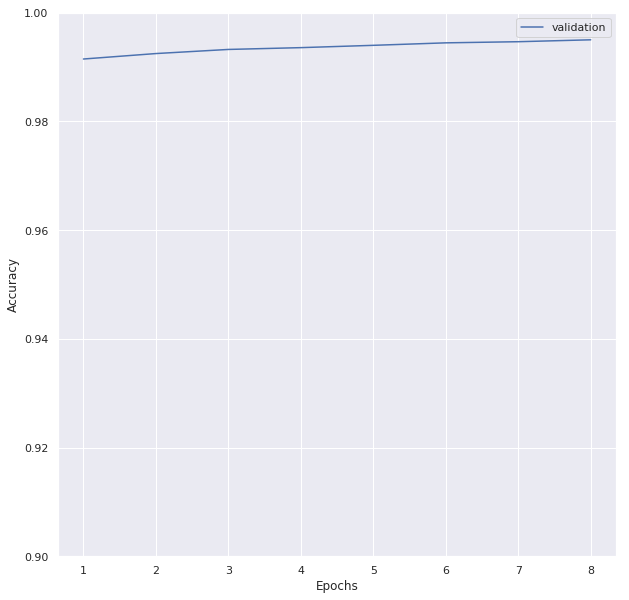

In [0]:
x = hist.history['acc']
plt.plot(range(1, len(x)+1), x,label="validation")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim([0.9, 1])
plt.legend()
plt.show()

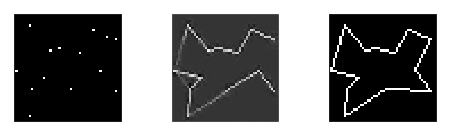

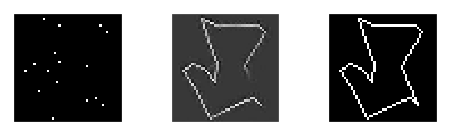

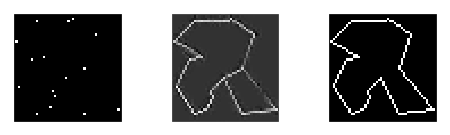

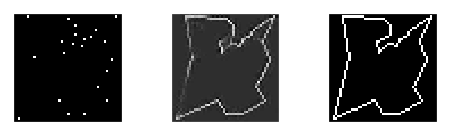

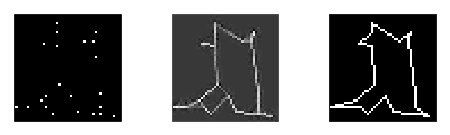

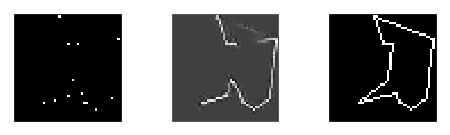

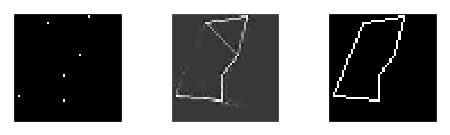

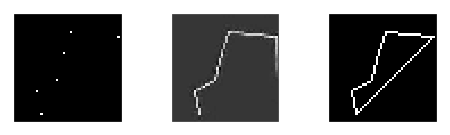

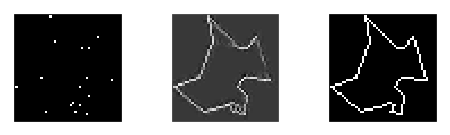

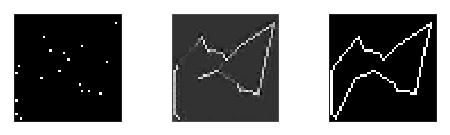

In [0]:
def test(X,Y,model):
    output = model.predict(X.reshape(1,48,48,1))
    output1 = output.reshape(48,48)
    output = output1
    fig = plt.figure(figsize=(8,2))
    subplot = fig.add_subplot(1,3,1)
    subplot.set_xticks([])
    subplot.set_yticks([])
    subplot.imshow(X.reshape(48,48))
    subplot = fig.add_subplot(1,3,2)
    subplot.set_xticks([])
    subplot.set_yticks([])
    subplot.imshow(output)
    subplot = fig.add_subplot(1,3,3)
    subplot.set_xticks([])
    subplot.set_yticks([])
    subplot.imshow(Y.reshape(48,48))
    
for i in range(10):
    (_,_,img,simg) = train[i+249]
    test(img,simg,model)
    

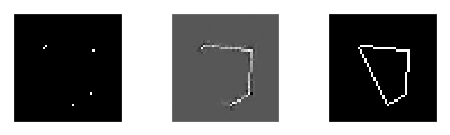

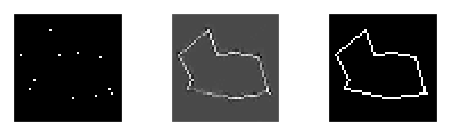

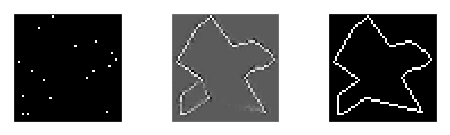

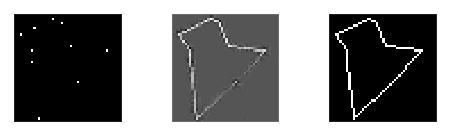

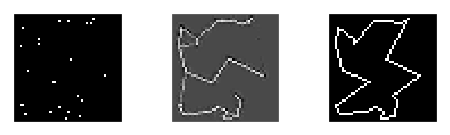

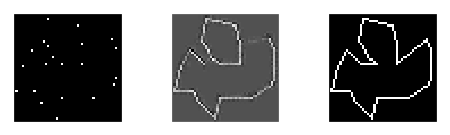

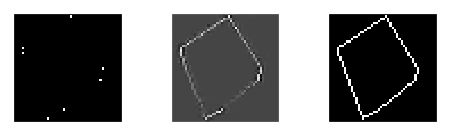

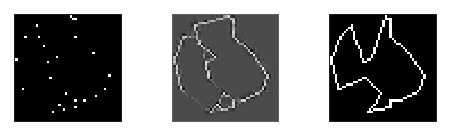

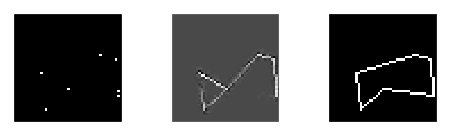

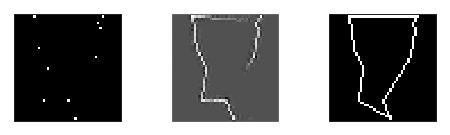

In [0]:
for i in range(10):
    (_,_,img,simg) = testdata[i+249]
    test(img,simg,model)    

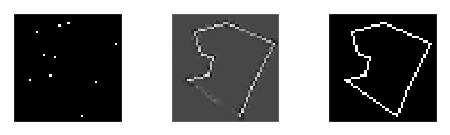

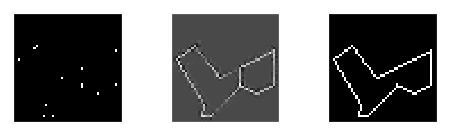

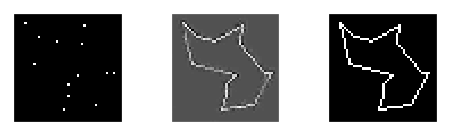

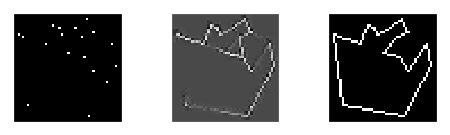

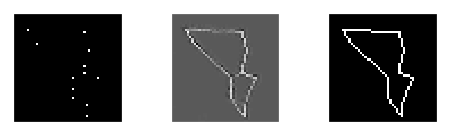

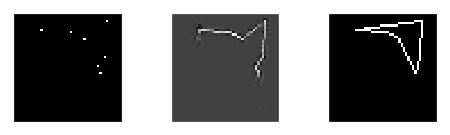

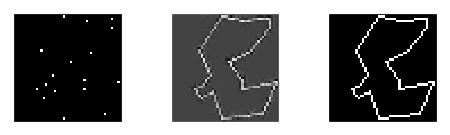

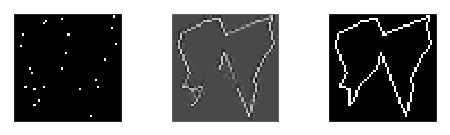

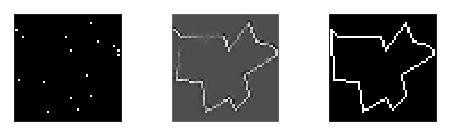

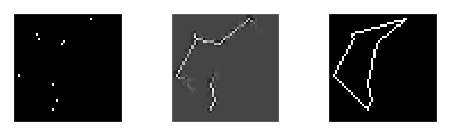

In [0]:
for i in range(10):
    (_,_,img,simg) = train[i+1249]
    test(img,simg,model)    